In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

E:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "copy",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1235 files belonging to 6 classes.


In [4]:
class_names = dataset.class_names
class_names

['Corynespora',
 'Healthy',
 'Pesta',
 'Powdery mildew',
 'birds eye',
 'colletorichum leaf disease']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 5 1 0 1 1 5 5 0 5 4 5 5 5 4 1 1 0 5 1 1 1 0 4 5 2 4 0 5 0 5 4]


# Visualizing images from the dataset

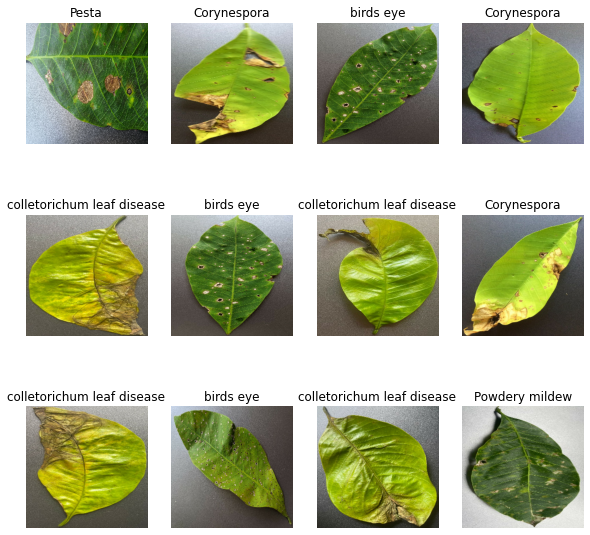

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

39

In [8]:
train_size = 0.8
len(dataset)*train_size

31.200000000000003

In [9]:
train_ds = dataset.take(31)
len(train_ds)

31

In [10]:
test_ds = dataset.skip(31)
len(test_ds)

8

In [11]:
val_size=0.1
len(dataset)*val_size

3.9000000000000004

In [12]:
val_ds = test_ds.take(3)
len(val_ds)

3

In [13]:
test_ds = test_ds.skip(3)
len(test_ds)

5

# Cache, Shuffle, and Prefetch the Dataset

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Data augmentation

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
import time

start_time = time.time()

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

end_time = time.time()



Epoch 1/25
31/31 [==============================] - 35s 1s/step - loss: 1.7403 - accuracy: 0.2440 - val_loss: 1.5661 - val_accuracy: 0.3854
Epoch 2/25
31/31 [==============================] - 38s 1s/step - loss: 1.3628 - accuracy: 0.4335 - val_loss: 1.2031 - val_accuracy: 0.5521
Epoch 3/25
31/31 [==============================] - 38s 1s/step - loss: 1.0909 - accuracy: 0.5675 - val_loss: 1.0020 - val_accuracy: 0.6146
Epoch 4/25
31/31 [==============================] - 39s 1s/step - loss: 0.8795 - accuracy: 0.6724 - val_loss: 0.8555 - val_accuracy: 0.6146
Epoch 5/25
31/31 [==============================] - 43s 1s/step - loss: 0.8290 - accuracy: 0.6815 - val_loss: 0.6895 - val_accuracy: 0.7812
Epoch 6/25
31/31 [==============================] - 54s 2s/step - loss: 0.6330 - accuracy: 0.7692 - val_loss: 0.5809 - val_accuracy: 0.7917
Epoch 7/25
31/31 [==============================] - 57s 2s/step - loss: 0.5157 - accuracy: 0.8065 - val_loss: 0.4540 - val_accuracy: 0.8542
Epoch 8/25
31/31 [==

In [36]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 2s 434ms/step - loss: 0.1318 - accuracy: 0.9500


In [38]:
training_time_seconds = end_time - start_time
training_time_minutes = training_time_seconds / 60  # Convert to minutes

print(f"Training time: {training_time_minutes:.2f} minutes")

Training time: 20.97 minutes


In [39]:
scores = model.evaluate(train_ds)

31/31 [==============================] - 12s 387ms/step - loss: 0.0791 - accuracy: 0.9768


In [40]:
scores = model.evaluate(val_ds)

3/3 [==============================] - 1s 246ms/step - loss: 0.1075 - accuracy: 0.9583


In [41]:
history

In [42]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 31}

In [43]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [44]:
type(history.history['loss'])

list

In [45]:
len(history.history['loss'])

25

In [46]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.7402602434158325,
 1.3628435134887695,
 1.090926170349121,
 0.8795458674430847,
 0.8290362358093262]

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [48]:
EPOCHS=25

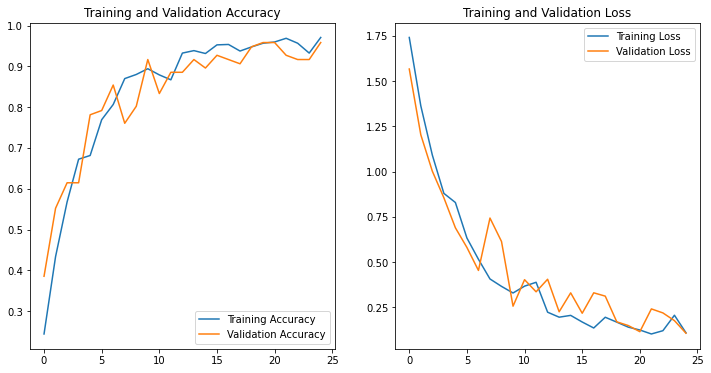

In [50]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Text(0.5, 1.0, 'Training and Validation Accuracy')

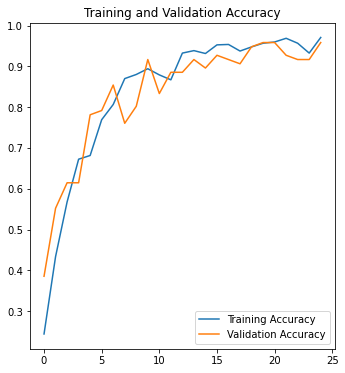

In [51]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

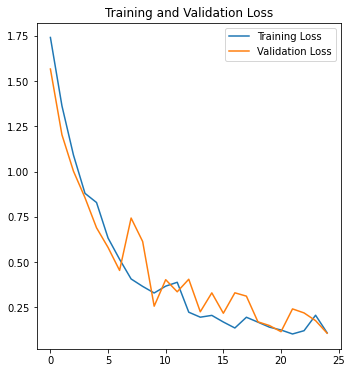

In [52]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: birds eye
1/1 [==============================] - 0s 289ms/step
predicted label: birds eye


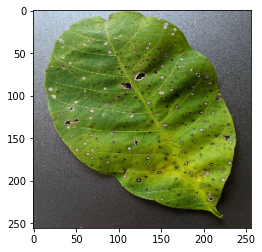

In [56]:
import numpy as np
import matplotlib.pyplot as plt

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[1].numpy().astype('uint8')
    first_label = labels_batch[1].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[1])])

# Getting predictions

In [59]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 30ms/step


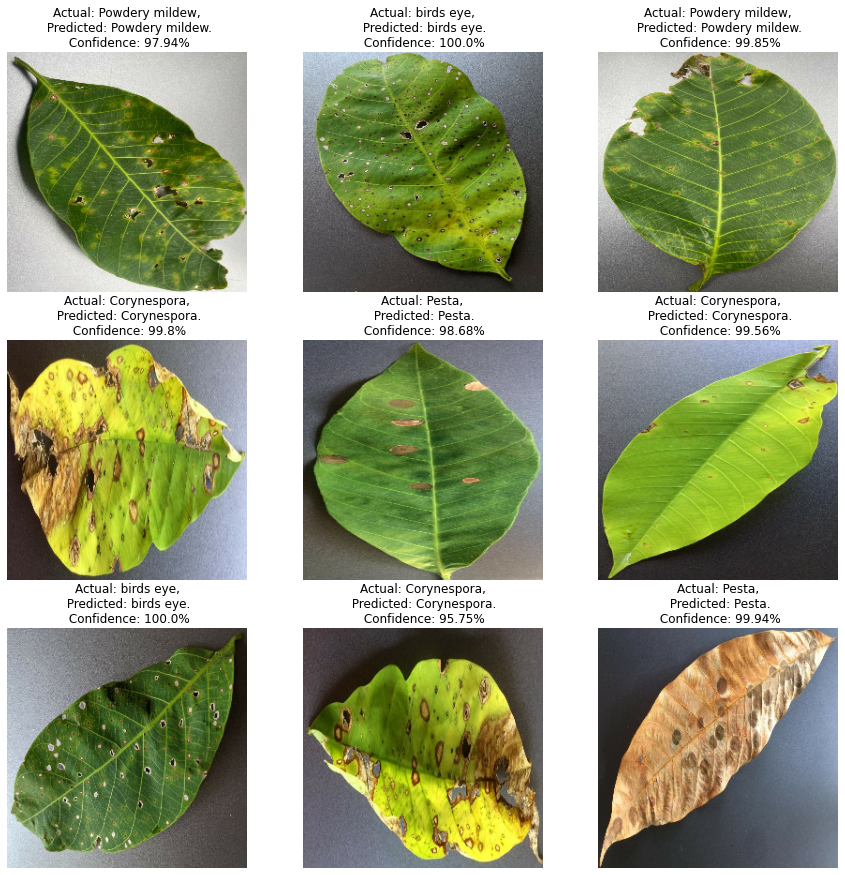

In [60]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

1/1 [==============================] - 0s 28ms/step


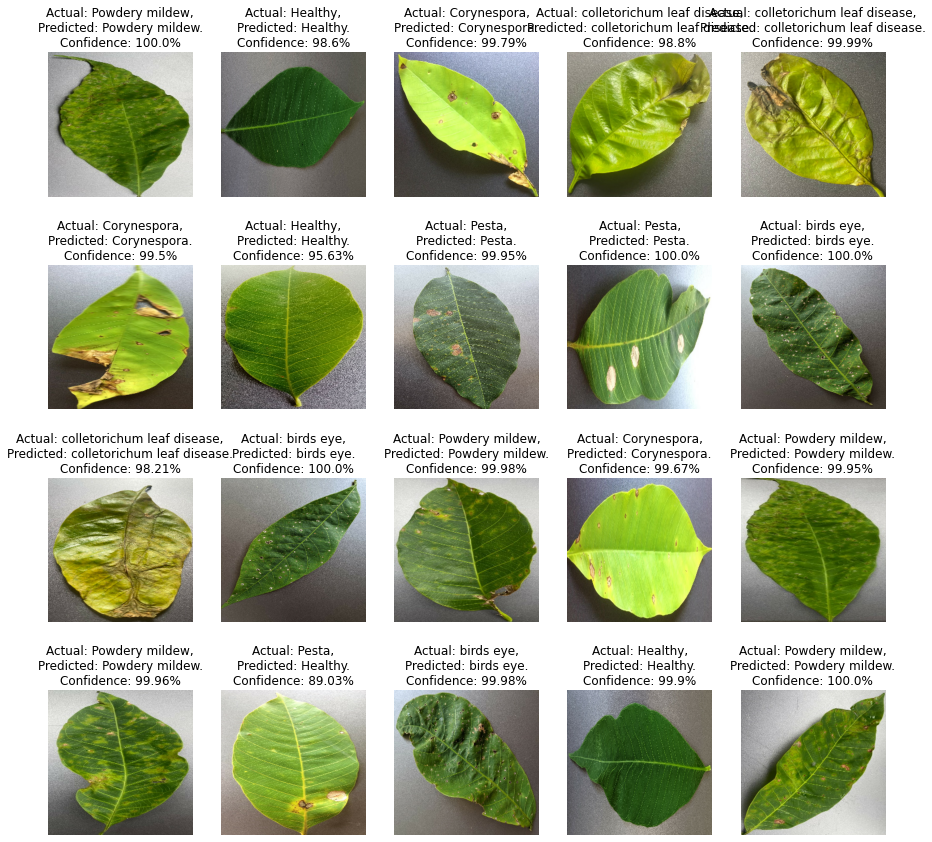

In [61]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    num_images = len(images)
    for i in range(min(20, num_images)):  # Get up to 20 images (or all available images)
        ax = plt.subplot(4, 5, i + 1)  # Adjust the subplot layout to fit 20 images
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}%")
        
        plt.axis("off")

In [82]:

predictions= model.predict(test_ds,batch_size=10,verbose=0)

In [93]:
predictions


array([[4.11387358e-04, 1.99268591e-02, 9.74118888e-01, 4.93967393e-03,
        5.78617211e-04, 2.45331375e-05],
       [1.12803171e-08, 9.41347241e-01, 4.53169970e-03, 5.41209094e-02,
        5.67105332e-08, 2.26292964e-12],
       [6.59254795e-07, 9.99327898e-01, 6.71271875e-04, 2.16251109e-07,
        5.72832448e-08, 1.19188522e-11],
       [3.45450946e-10, 9.73851420e-05, 5.72780345e-06, 9.99895573e-01,
        1.28236888e-06, 6.58165411e-10],
       [4.44880174e-11, 3.47532279e-13, 2.94674831e-12, 1.09754774e-06,
        9.99998927e-01, 2.06538986e-09],
       [9.93031144e-01, 2.13285908e-04, 5.11927716e-03, 2.70973601e-07,
        6.29613642e-04, 1.00636831e-03],
       [6.64430899e-10, 5.83398043e-12, 5.49981172e-10, 5.37582537e-07,
        9.99999404e-01, 2.63784350e-09],
       [4.56665111e-06, 5.70110604e-03, 1.27400155e-03, 9.92218494e-01,
        7.57495931e-04, 4.43142781e-05],
       [1.04334385e-05, 1.00277191e-06, 4.66737343e-04, 1.08681552e-05,
        4.25615281e-06, 

In [97]:
import tensorflow as tf

# Assuming you've defined and compiled your 'model' here

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Specify the full path including the directory and file name
tflite_model_path = "C:\\Users\\User\\Desktop\\FYP(M for Reports)\\custom_cnn\\disease_and_others_together\\Sequential(CNN).tflite"


with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpnq3w9b64\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpnq3w9b64\assets
